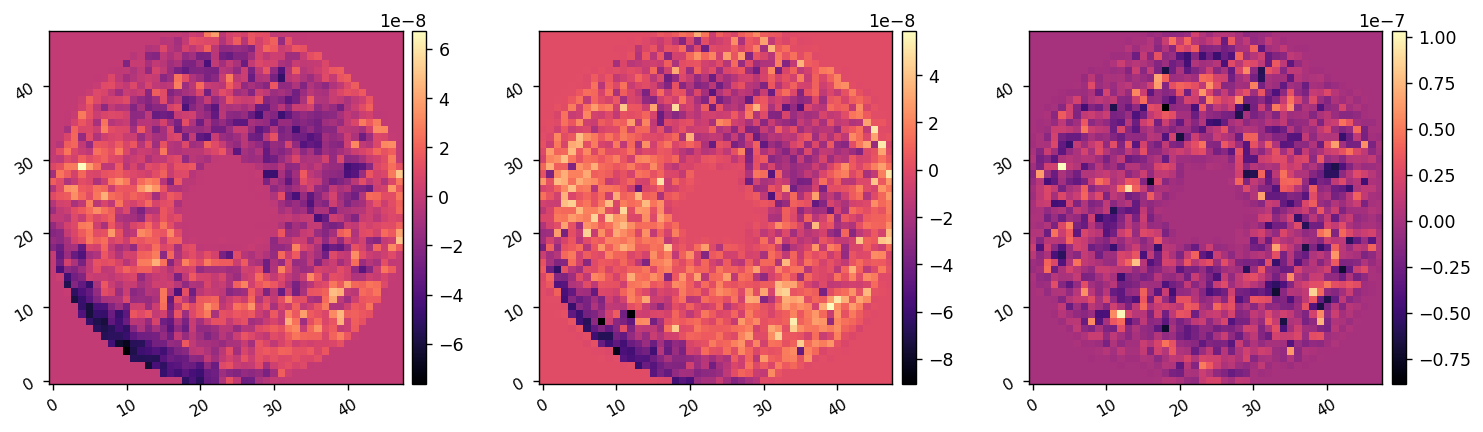

0.2888459971450042


In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from IPython.display import clear_output, display
import time
from pathlib import Path
import copy

import proper
proper.prop_use_fftw(DISABLE=False)

import roman_phasec_proper

import cgi_phasec_poppy as cgi
import cgi_phasec_poppy.imshows as imshows
from cgi_phasec_poppy.imshows import *
import ray

from importlib import reload

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')
data_dir = Path('/npool/nvme/kianmilani/disk-data')

dm1_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm1.fits')
dm2_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm2.fits')
imshow3(dm1_best, dm2_best, dm1_best-dm2_best)

wavelength_c = 825e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

npsf = 256
psf_pixelscale_mas = 20.8*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
print(psf_pixelscale_lamD)
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

polaxis = 2

iwa = 6
owa = 20

In [14]:
proper.prop_use_ffti()
proper.prop_use_fftw()

Intel MKL Library not found. Using Numpy FFT.


4231

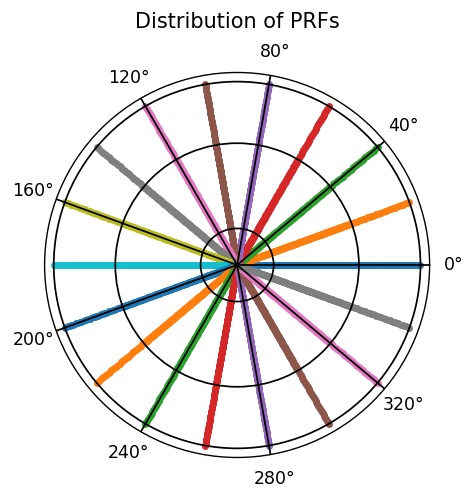

In [4]:
# Create the sampling grid the PSFs will be made on
sampling1 = 0.1
sampling2 = 0.1
sampling3 = psf_pixelscale_lamD
offsets1 = np.arange(0,iwa+1,sampling1)
offsets2 = np.arange(iwa+1,owa,sampling2)
offsets3 = np.arange(owa,30+sampling3,sampling3)

r_offsets = np.hstack([offsets1, offsets2, offsets3])
nr = len(r_offsets)
r_offsets_mas = r_offsets*mas_per_lamD
# display(nr, r_offsets)

sampling_theta = 20
thetas = np.arange(0,360,sampling_theta)*u.deg
nth = len(thetas)
# display(nth, thetas)

psfs_required = (nr-1)*nth + 1
display(psfs_required)

# r_offsets_hdu = fits.PrimaryHDU(data=r_offsets)
# r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20230501.fits'
# r_offsets_hdu.writeto(r_offsets_fpath, overwrite=True)

# thetas_hdu = fits.PrimaryHDU(data=thetas.value)
# thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20230501.fits'
# thetas_hdu.writeto(thetas_fpath, overwrite=True)

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(4,4))

ax1 = plt.subplot(111, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.', )
ax1.set_yticklabels([])
ax1.set_rticks([iwa, owa, max(r_offsets)],)  # Less radial ticks
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.set_thetagrids(thetas[::2].value)
ax1.grid(axis='x', visible=True, color='black', linewidth=1)
ax1.grid(axis='y', color='black', linewidth = 1)
ax1.set_title('Distribution of PRFs', va='bottom')
ax1.set_axisbelow(False)

In [18]:
4231*70/3600

82.26944444444445

In [10]:
nlam = 7
lam0 = 0.825
bandwidth = 0.1
minlam = lam0 * (1 - bandwidth/2)
maxlam = lam0 * (1 + bandwidth/2)
lam_array = np.linspace( minlam, maxlam, nlam )

options = {'cor_type':'spc-wide', # change coronagraph type to correct band
           'final_sampling_lam0':psf_pixelscale_lamD, 
           'source_x_offset':0,
           'source_y_offset':0,
           'use_fpm':1,
           'use_field_stop':1,
           'use_errors':1,
           'use_lens_errors':1,
           'use_hlc_dm_patterns':0,
           'use_dm1':1, 'dm1_m':dm1_best, 
           'use_dm2':1, 'dm2_m':dm2_best,
           'polaxis':polaxis,   
          }



In [8]:
lam_array = np.array([0.825])

Lambda = 8.2500E-07   Throughput = 1.00Lambda = 7.9750E-07   Throughput = 1.00Lambda = 7.8375E-07   Throughput = 1.00Lambda = 8.3875E-07   Throughput = 1.00Lambda = 8.1125E-07   Throughput = 1.00




Lambda = 8.5250E-07   Throughput = 1.00Lambda = 8.6625E-07   Throughput = 1.00

Applying lens
Applying lensApplying lens

Applying lens
Applying lens
Applying lensApplying lens

Propagating to secondary
Propagating to secondary
Propagating to secondary
Propagating to secondary
Propagating to secondary
Propagating to secondary
Propagating to secondary
Applying lens
Applying lens
Applying lens
Applying lens
Applying lens
Applying lens
Applying lens
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to M3
Propagating to M3
Propagating to M3
Propagating to M3
Propagating to M3
Propagating to M3
Propagating to M3
Applying lens
Applying lens
Applying lens
Applyi

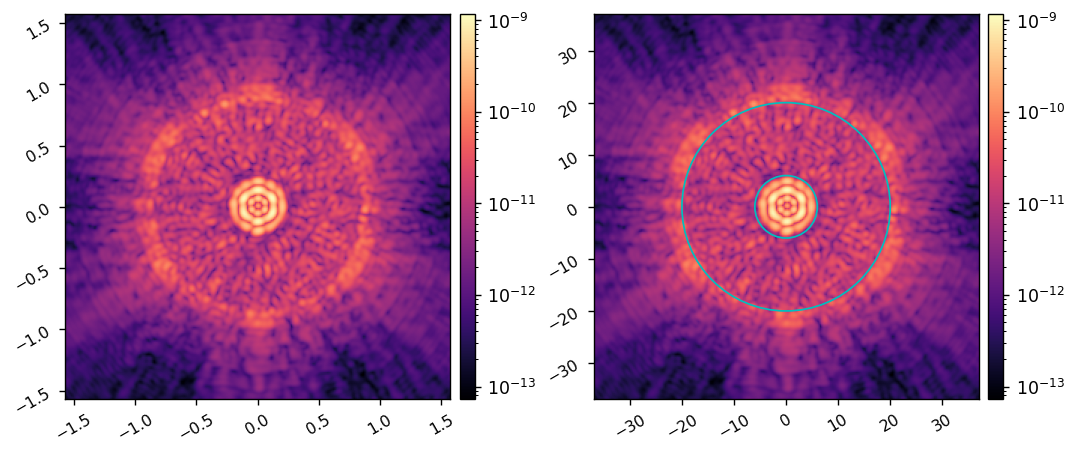

In [11]:
(wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=False, PASSVALUE=options)

psfs = np.abs(wfs)**2
psf_bb = np.sum(psfs, axis=0)/nlam
psf_pixelscale_m = pxscls_m[0]*u.m/u.pix

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
imshow2(psf_bb, psf_bb,
               lognorm1=True, lognorm2=True, 
               pxscl1=psf_pixelscale_m.to(u.mm/u.pix), pxscl2=psf_pixelscale_lamD, patches2=patches)

In [21]:
r_offsets[0]

0.0

(256, 256)


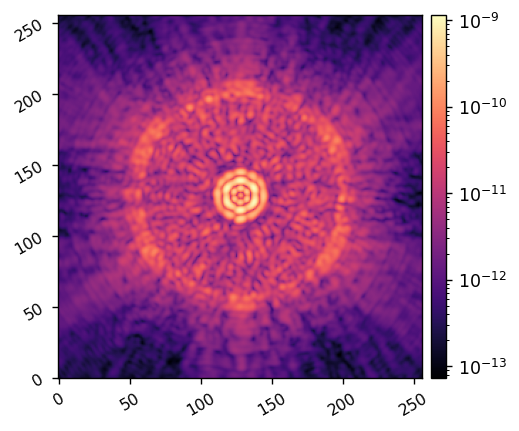

0 74.02223181724548
(256, 256)


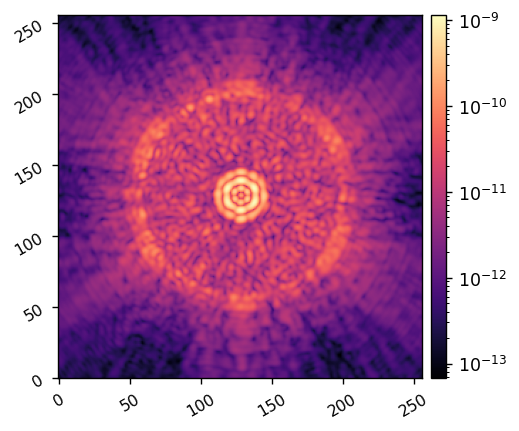

1 146.34270215034485
(256, 256)


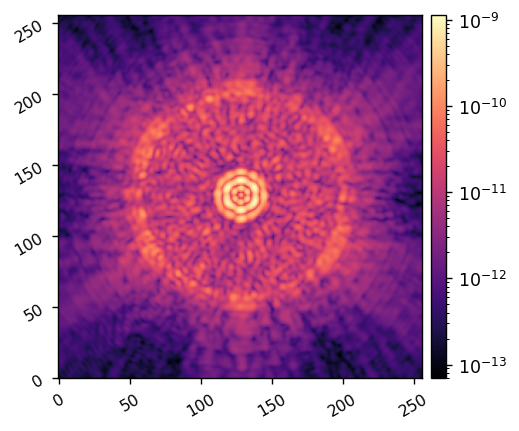

2 217.61289072036743


KeyboardInterrupt: 

In [19]:
psfs_array = np.zeros( shape=( (len(r_offsets)-1)*len(thetas) + 1, npsf,npsf) )

count = 0
start = time.time()
for i,r in enumerate(r_offsets): 
    for j,th in enumerate(thetas):
        xoff = r*np.cos(th)
        yoff = r*np.sin(th)
        options.update( {'source_x_offset':xoff.value, 'source_y_offset':yoff.value} )
    
        (wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=True, PASSVALUE=options)

        psfs = np.abs(wfs)**2
        psf = np.sum(psfs, axis=0)/nlam
        
        print(psf.shape)
        imshow1(psf, lognorm=True)
        
        print(count, time.time()-start)
        psfs_array[count] = psf
        count += 1

        if r<r_offsets[1]: 
            break # skip first set of PSFs if radial offset is 0 at the start
        

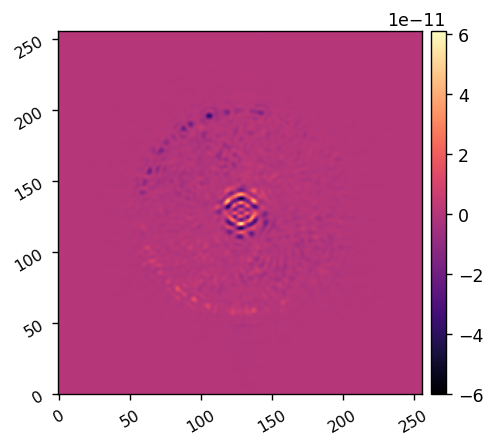

In [22]:
imshow1(psfs_array[2]-psfs_array[1])

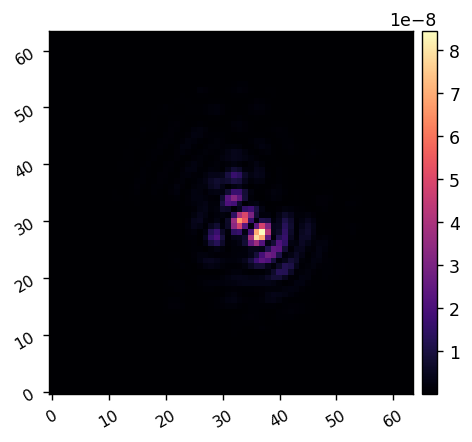

In [23]:
psfs = fits.getdata(data_dir/'psfs'/f'hlc_band1_psfs_polaxis-2_20240418.fits')
imshow1(psfs[60])

In [23]:
psfs_array.size * psfs_array.itemsize/1e9

2.218262528

# Interpolate the PSFs for the grid of the model

In [55]:
psfs = fits.getdata(data_dir/'psfs'/f'hlc_band1_psfs_polaxis-2_20240418.fits')
print(psfs.shape, len(psfs))

from scipy.ndimage import rotate
def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    if kr>(len(r_offsets)-1):
        kr = len(r_offsets)-1
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: 
        kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=1)
    
    return interpped_psf

(4249, 64, 64) 4249


Desired r=216.00 mas, radial index=22, closest available r=220.83 mas
Desired th=7.50 deg, theta index=1, closest available th=5.00 deg, difference=2.50 deg
PSF index = 1514


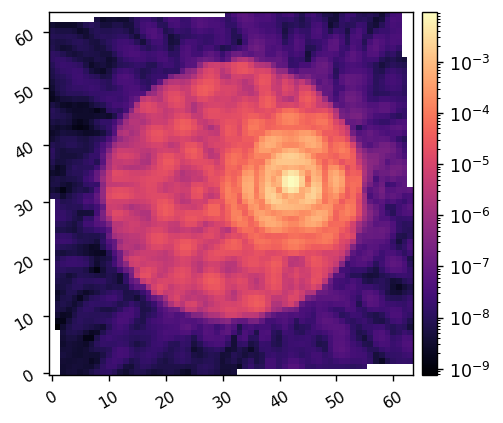

In [56]:
r = 216*u.mas
th = 7.5*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

imshow1(psf, lognorm=True)

Desired r=200.00 mas, radial index=20, closest available r=200.76 mas
Desired th=50.00 deg, theta index=10, closest available th=50.00 deg, difference=0.00 deg
PSF index = 1379


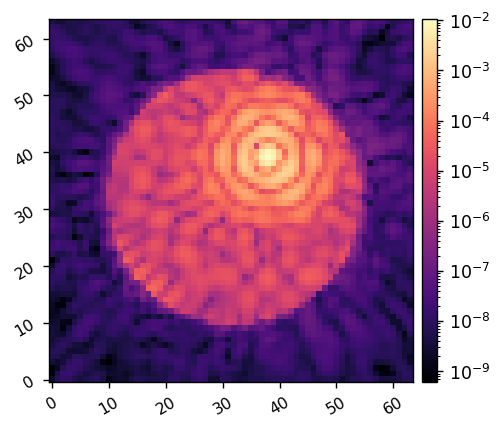

In [58]:
r = 200*u.mas
th = 50*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

imshow1(psf, lognorm=True)


# Create grid coordinates for the model

In [61]:
ndisk = 100
disk_pixelscale_mas = 20.8*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

<Quantity [-1029.6, -1008.8,  -988. , ...,   988. ,  1008.8,  1029.6] mas>

In [62]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

9999 6.023616790771484


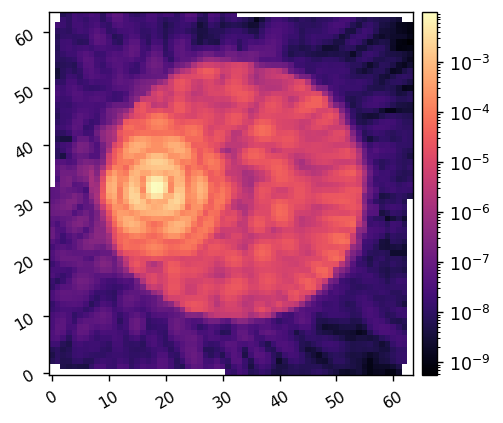

In [73]:
imshow1(ipsf_matrix[:,5035].reshape(npsf,npsf), lognorm=True)

In [ ]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_072022.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()